In [10]:
%load_ext autoreload
%autoreload 2

from typing import Literal
from itertools import combinations
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
from pgmpy.models.MarkovNetwork import MarkovNetwork
from pgmpy.models import DiscreteBayesianNetwork


from tabicl.prior.prior_config import DEFAULT_FIXED_HP, DEFAULT_SAMPLED_HP
from tabicl.prior.dataset import PriorDataset
from tabicl.prior._graph import _marginalize_nodes_array

from gtdl.graph.scm import get_graph
from gtdl.viz.graph import draw_scms
from gtdl.graph.moral_marg import old_check

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/elias/EliasMBA/Projects/PhD/TFM/gtdl/gtdl/viz/graph.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  nodelists = [nodelists] if nodelists is not None else None


### Generate

In [11]:
scm_fixed_hp = {
    **DEFAULT_FIXED_HP,
    'is_causal': True,
    'in_clique': False,
    # 'block_wise_dropout': False,
    'mlp_dropout_prob': 0.4,
    'num_layers': 4,
    'hidden_dim': 3,
    'num_causes': 2,
}
scm_sampled_hp = {k: v for k, v in DEFAULT_SAMPLED_HP.items() if k not in scm_fixed_hp}

min_features = 5
dataset = PriorDataset(
    batch_size = 24,
    min_features = min_features,
    max_features = min_features,
#     max_classes = 3,
    batch_size_per_gp = 1, # slows dows, but for visualization it's ok
    scm_fixed_hp=scm_fixed_hp,
    scm_sampled_hp=scm_sampled_hp,
)

xs, ys, ds, seq_lens, train_sizes, adjs_prior, priors = dataset.prior.get_batch()
print(f'{len(priors) = }')

len(priors) = 24


In [12]:
adjs, graphs = [], []

adjs_marg, graphs_marg = [], []
nodelists = []

for prior in priors:

    adj = prior.adj_full.numpy()
    adj = (np.abs(adj) > 0.)
    indices = (idxs_x, idxs_y) = [idx_i.numpy() for idx_i in prior.indices]
    width_layers = np.concatenate([[prior.num_causes], [prior.hidden_dim] * prior.num_layers])

    graph = get_graph(adj, width_layers, idxs_x, idxs_y)

    adj_marg = _marginalize_nodes_array(adj, indices_to_remove = graph.graph['nodes_exclude'])
    graph_marg = get_graph(adj_marg, width_layers, idxs_x, idxs_y)

    graphs.append(graph)
    adjs.append(adj)
    
    nodelists.append(graph.graph['nodes_include'])
    graphs_marg.append(graph_marg)
    adjs_marg.append(adj_marg)

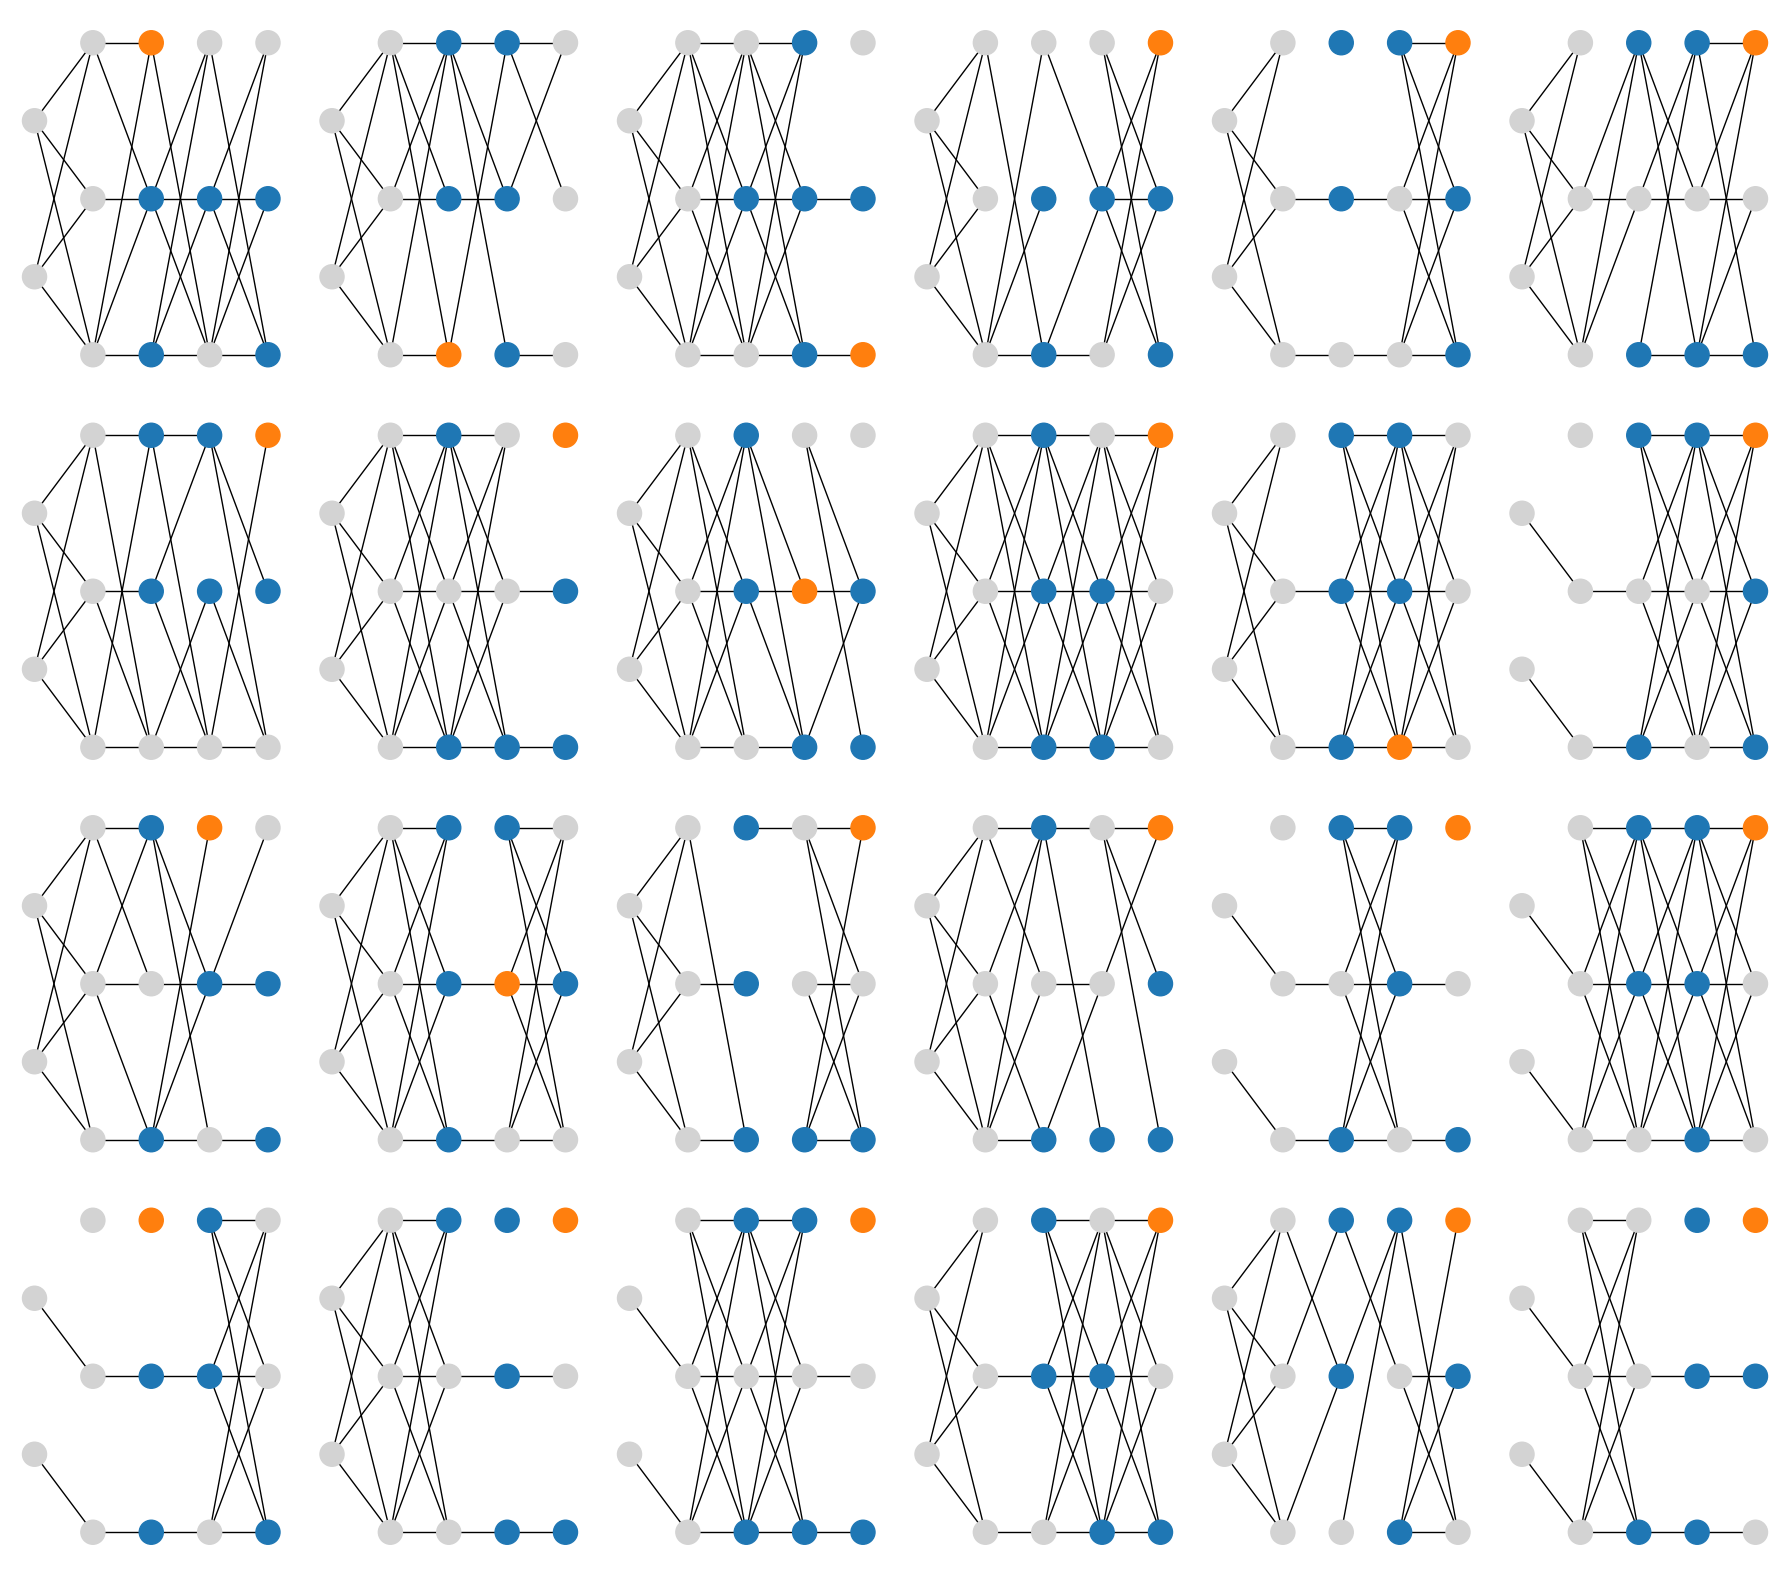

In [13]:
n_cols = 6
cmap = ListedColormap(['white', 'black'])

draw_scms(
    graphs, 
    # suptitle='Original graph',
    # edge_alpha = 1.,
    n_rows = np.ceil(len(graphs) / n_cols).astype(int),
    figsize = (3, 4),
)

# for j, i in enumerate(range(0, len(adjs), n_cols)):
#     idx_slice = slice(i, i+n_cols)

#     draw_scms(graphs[idx_slice], suptitle='Original graph',
#         edge_alpha = 1.,
#     )
#     imshow(adjs[idx_slice], cmap = cmap, suptitle='Original adjacency matrix (full)')

#     # draw_scms(graphs_marg[idx_slice], suptitle='Marginalized graph (only included nodes)',
#     #     edge_alpha = 1.,
#     #     nodelists = nodelists[idx_slice],
#     # )
#     # imshow(adjs_marg[idx_slice], cmap = cmap, suptitle='Marginalized adjacency matrix (full)')
#     # adj_marg_sel = [adj_marg[np.ix_(nodelist, nodelist)] for adj_marg, nodelist in zip(adjs_marg[idx_slice], nodelists[idx_slice])]
#     # imshow(adj_marg_sel, cmap = cmap, turn_off_axis='only_border', suptitle='Marginalized adjacency matrix (only included nodes)')

#     # if j > 0: break
#     print('\n\n\n\n')


### Variable elimination

len(graphs) = 24


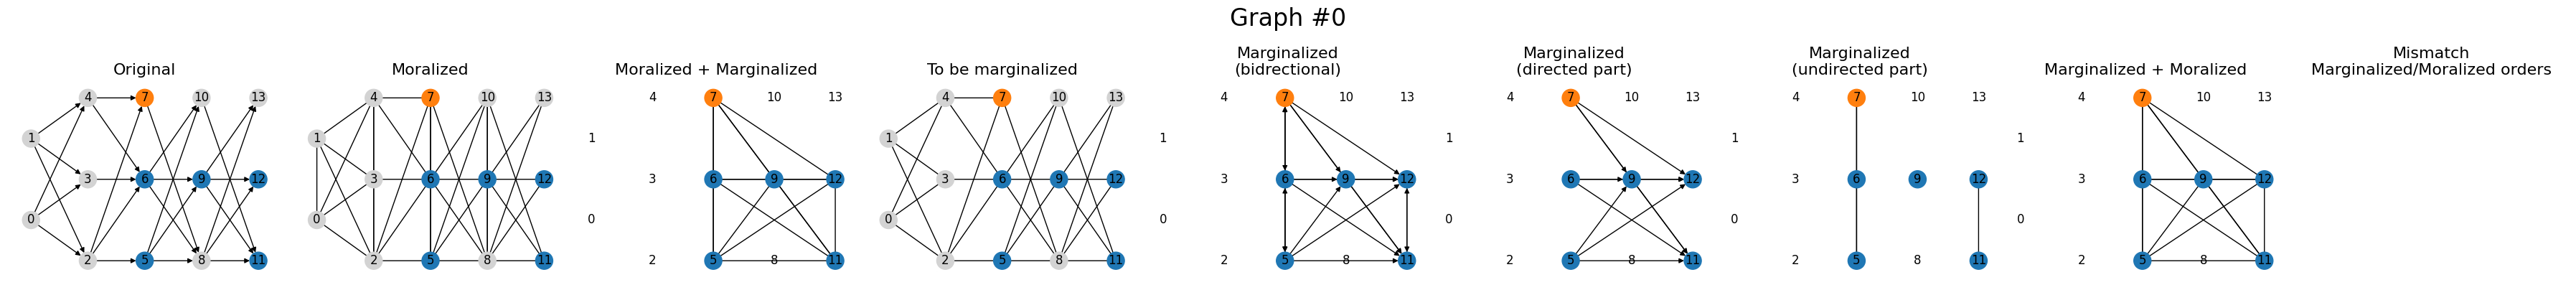

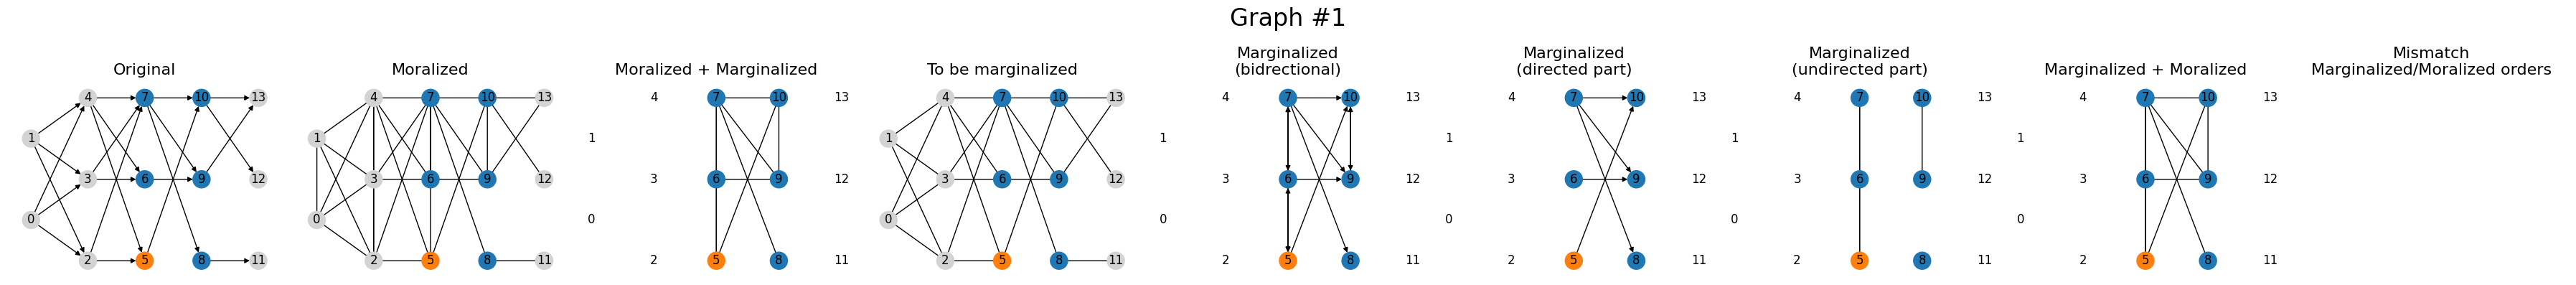

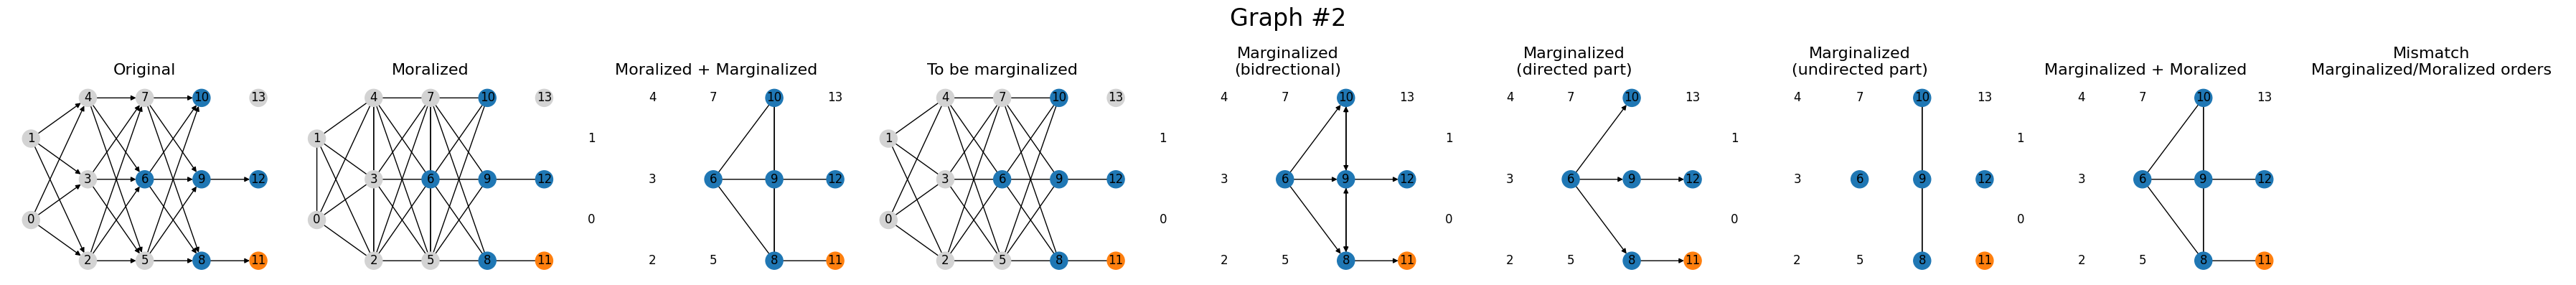

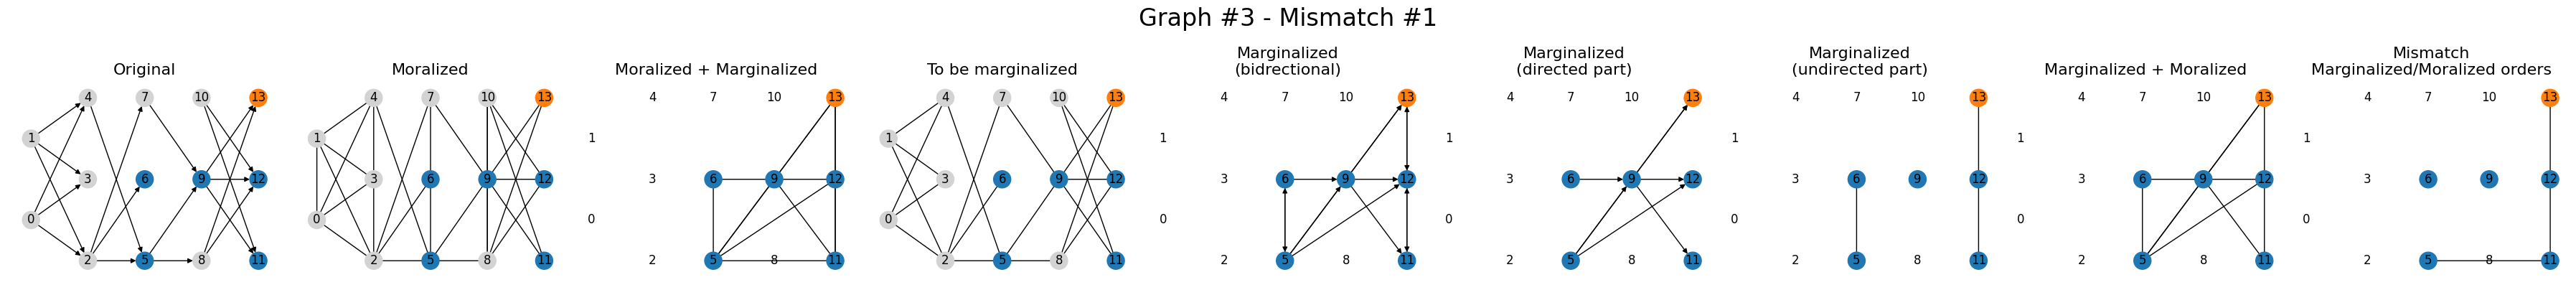

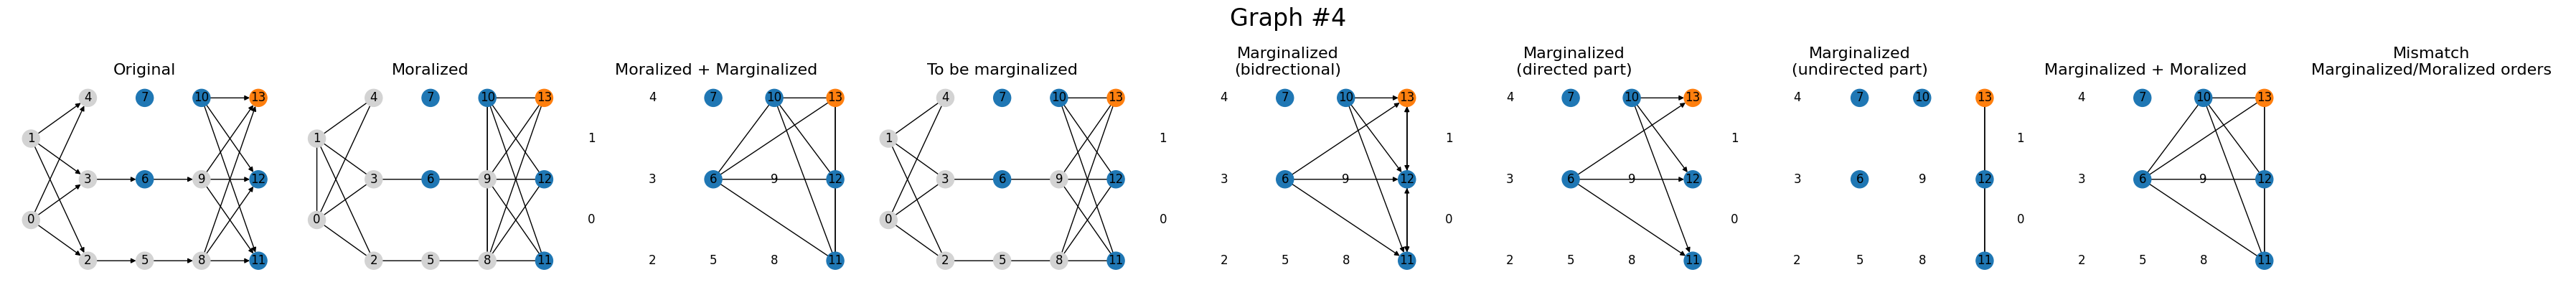

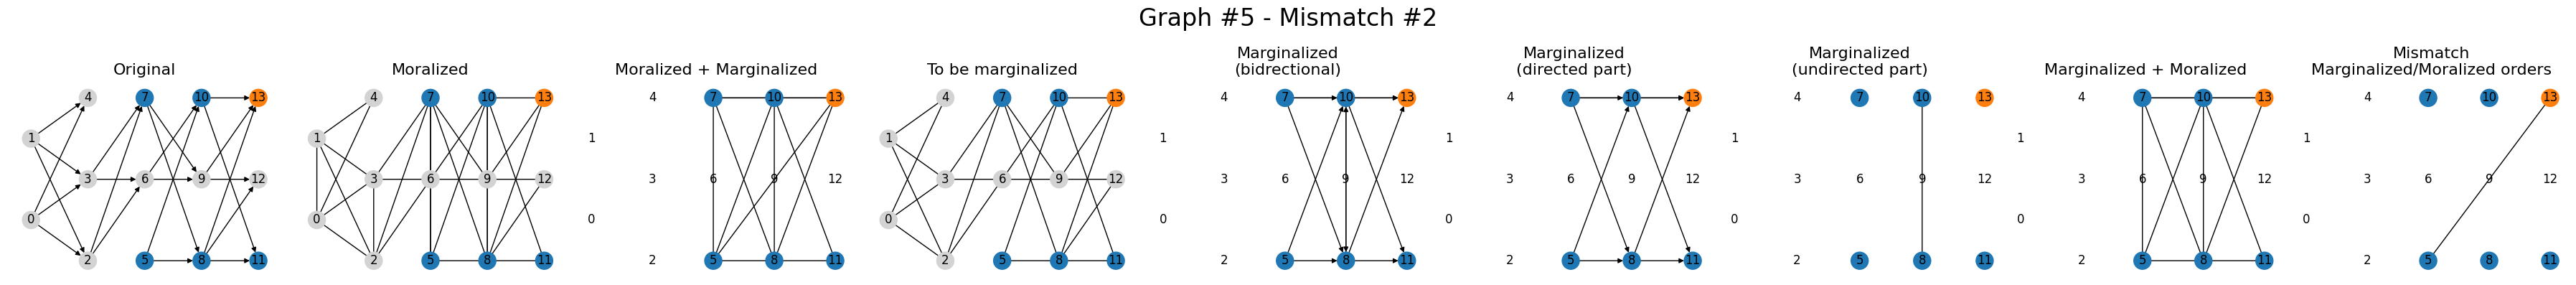

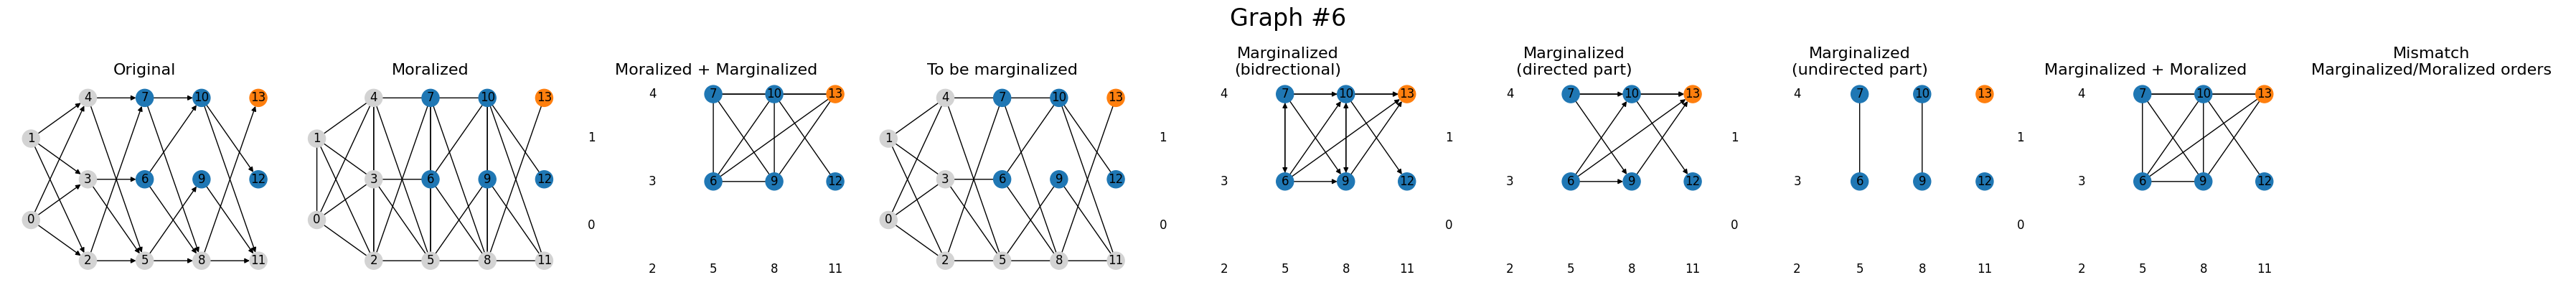

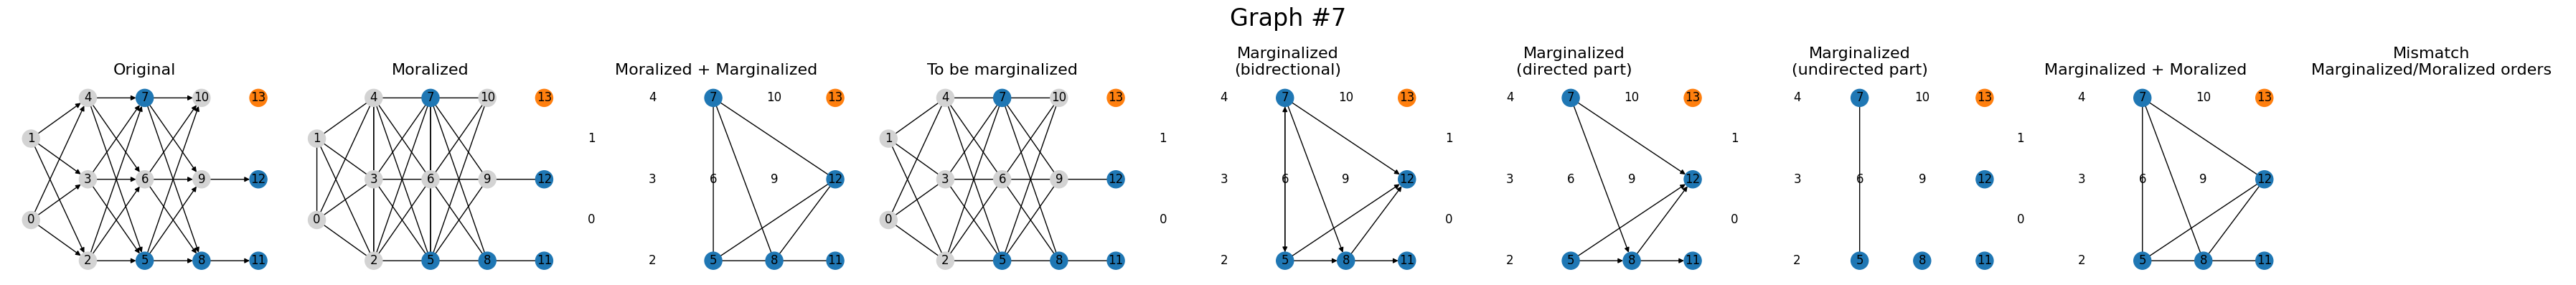

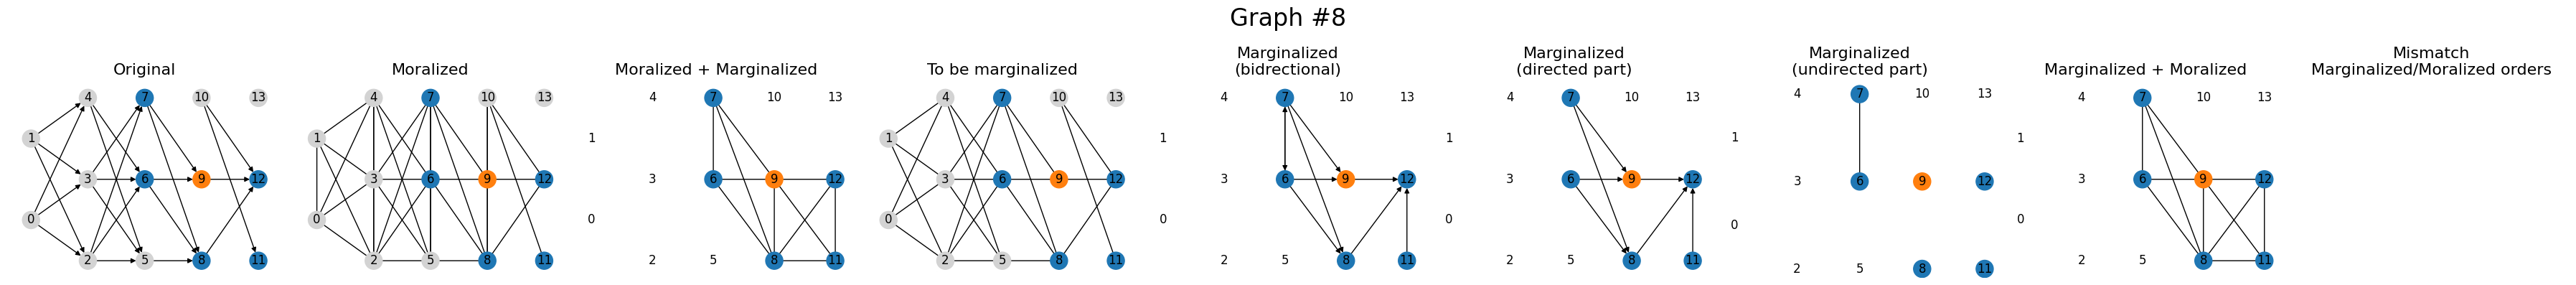

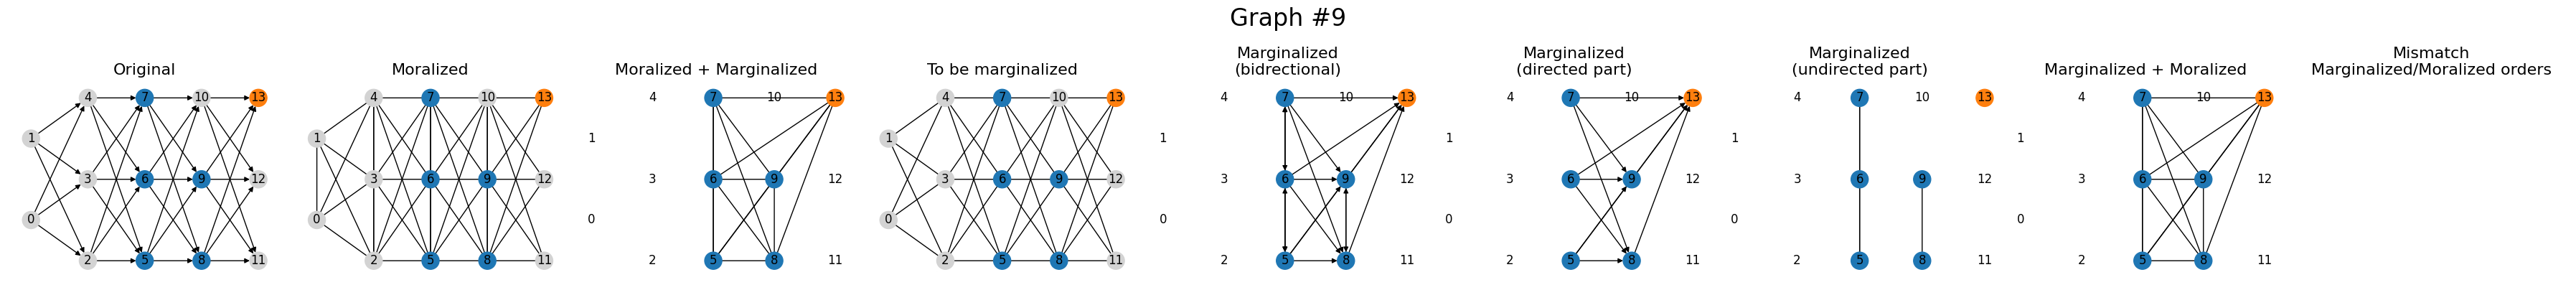

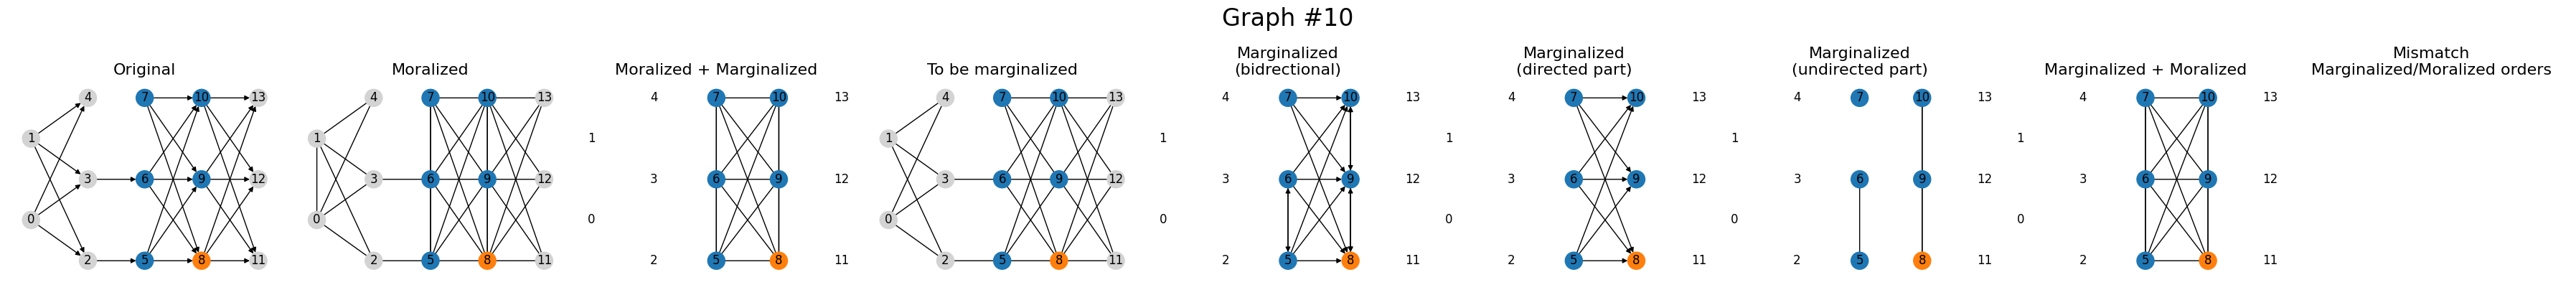

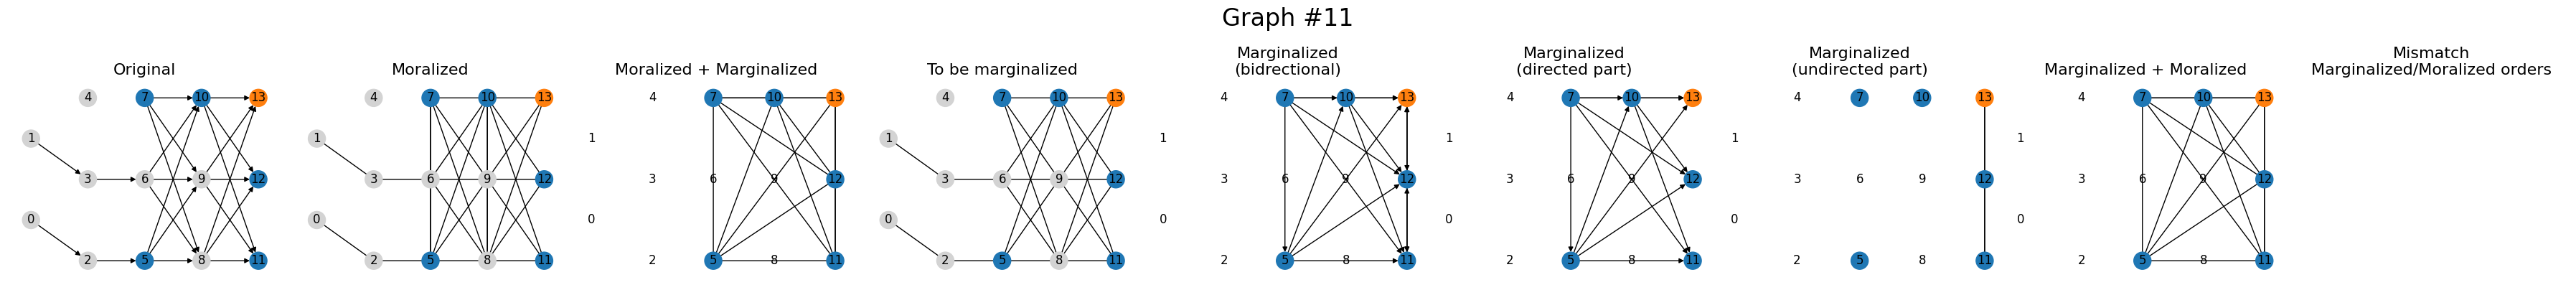

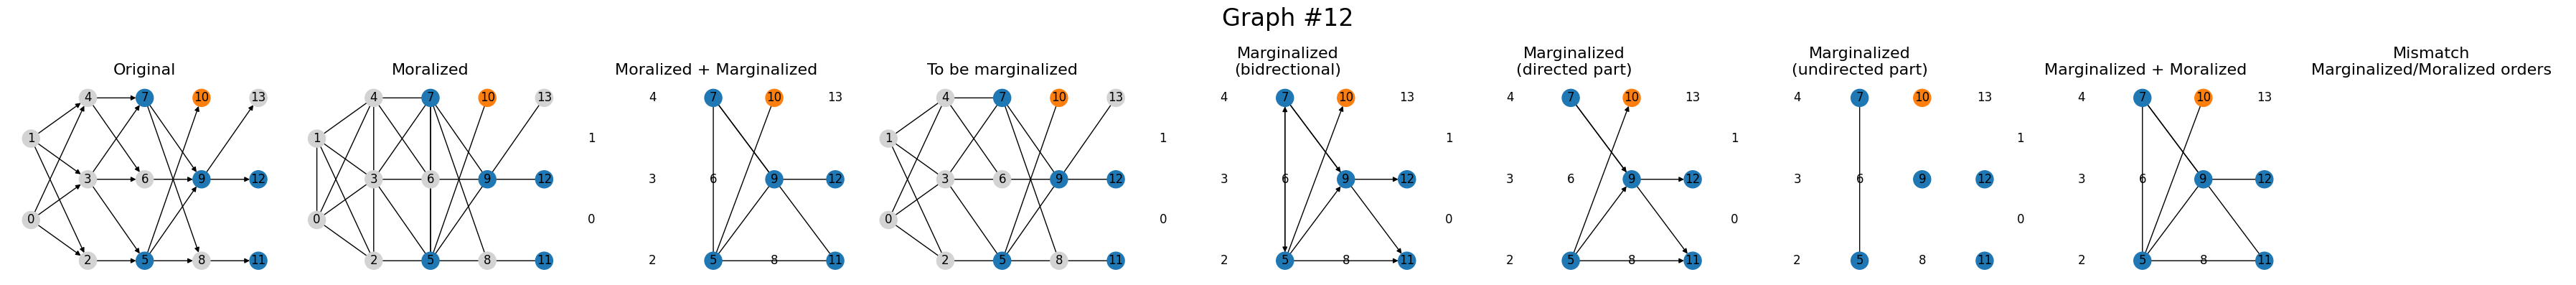

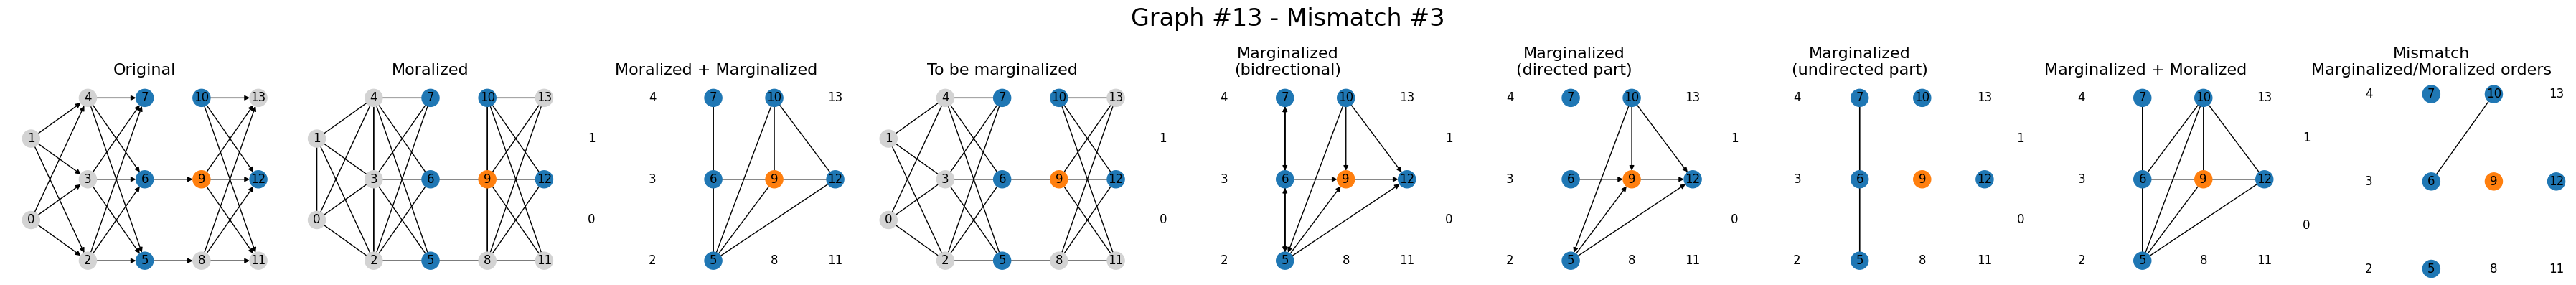

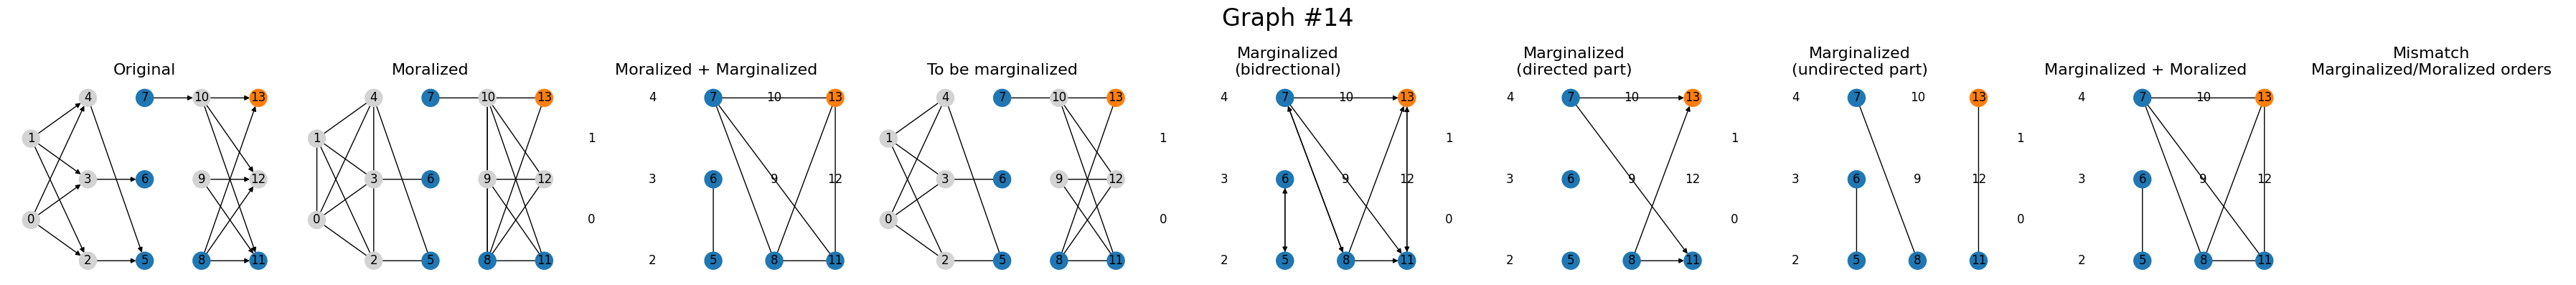

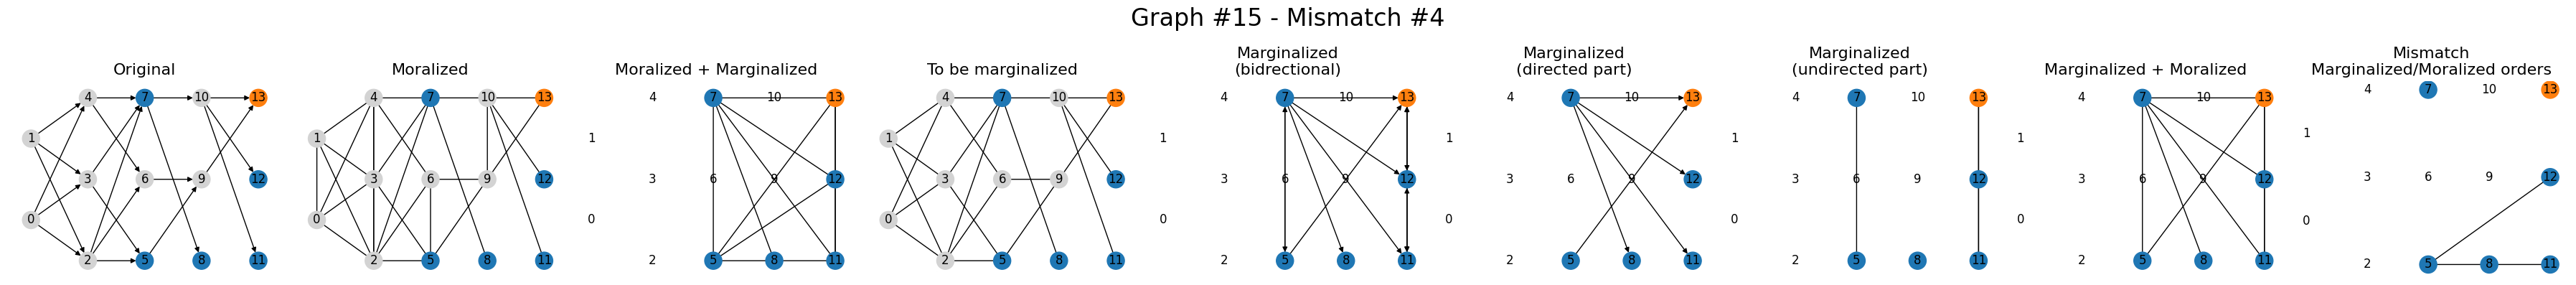

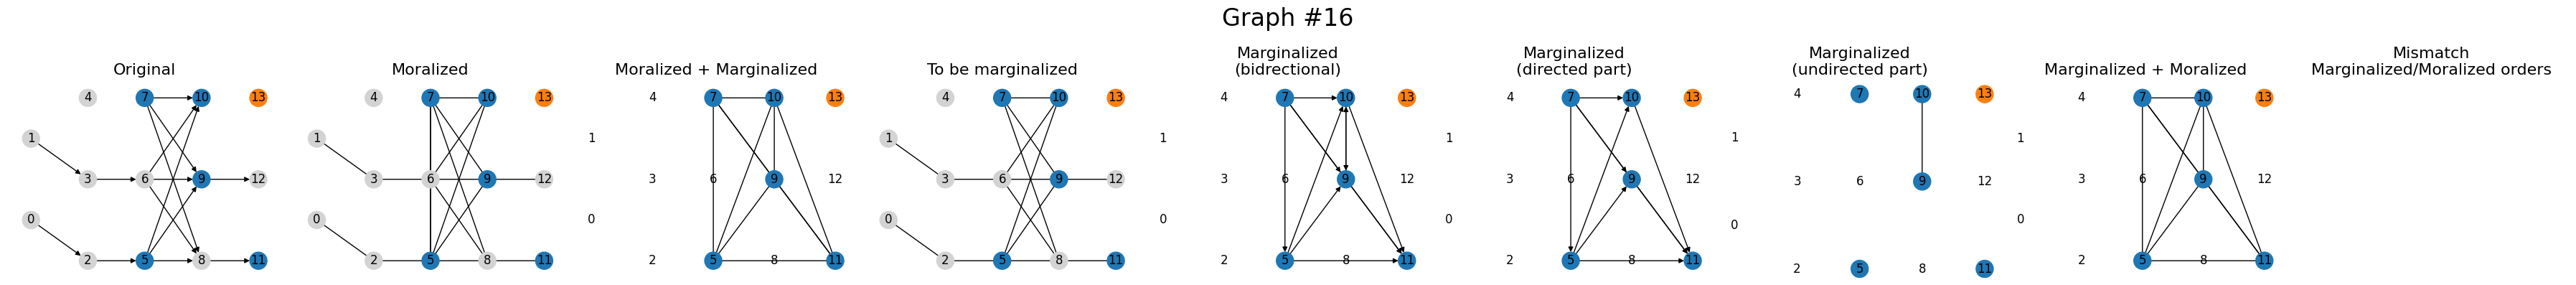

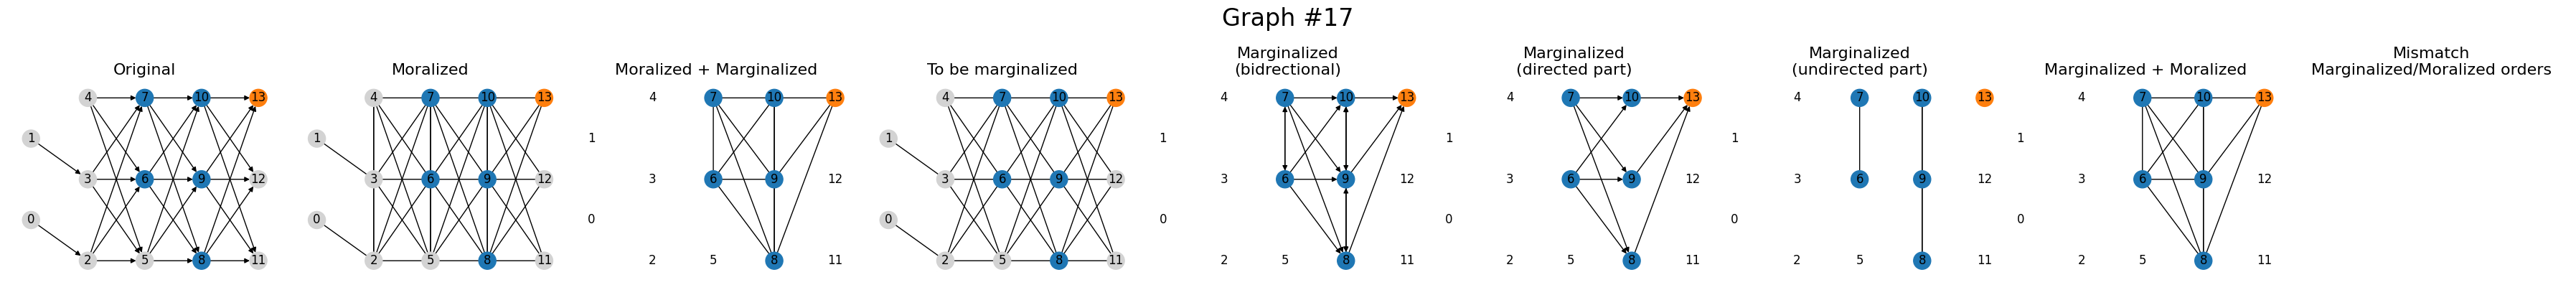

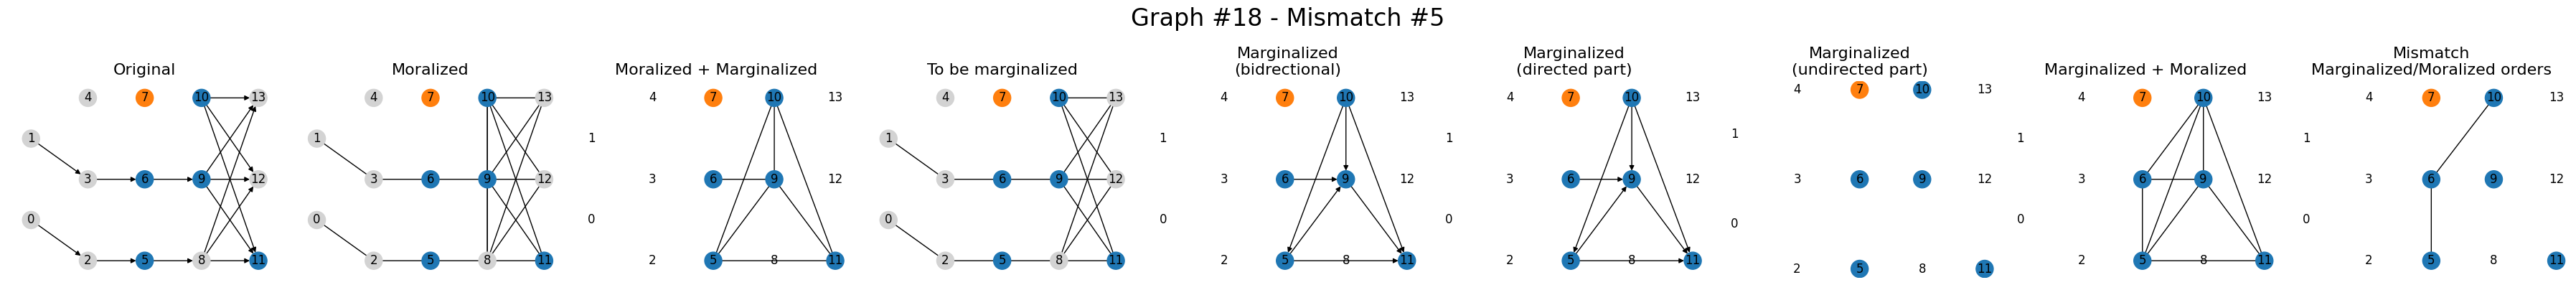

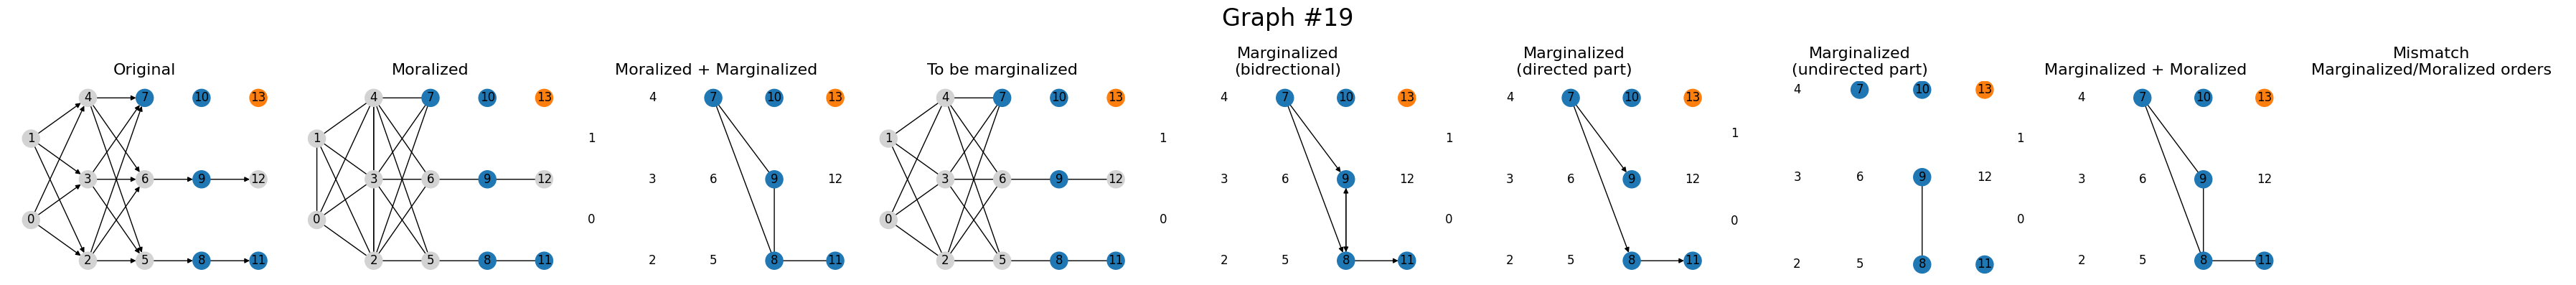

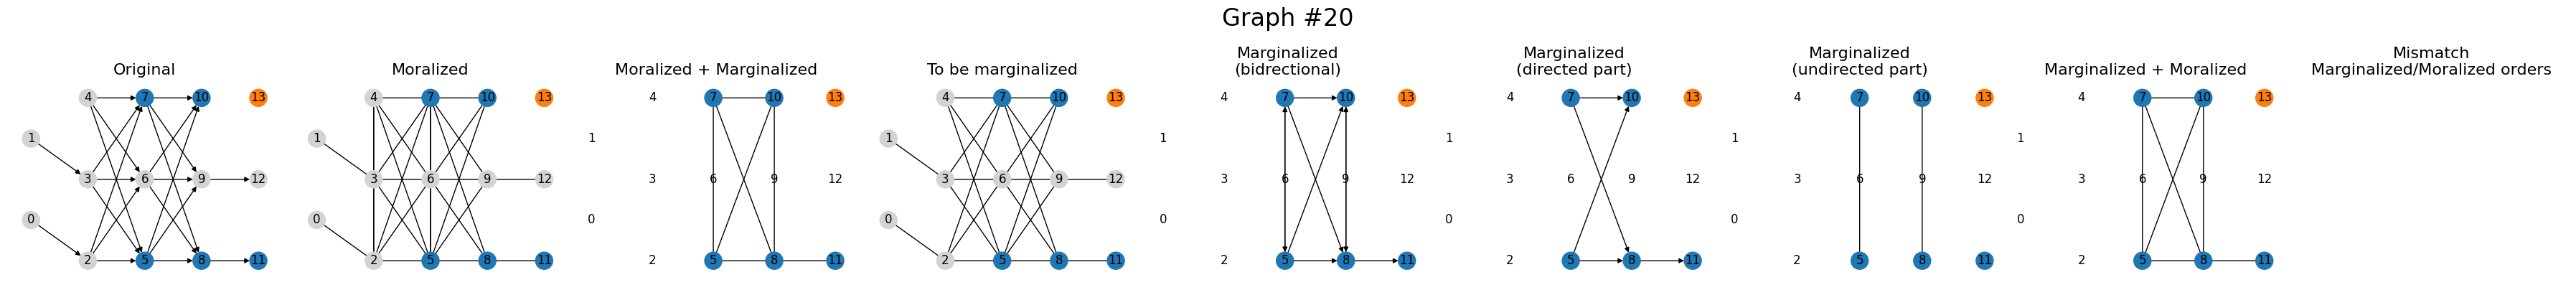

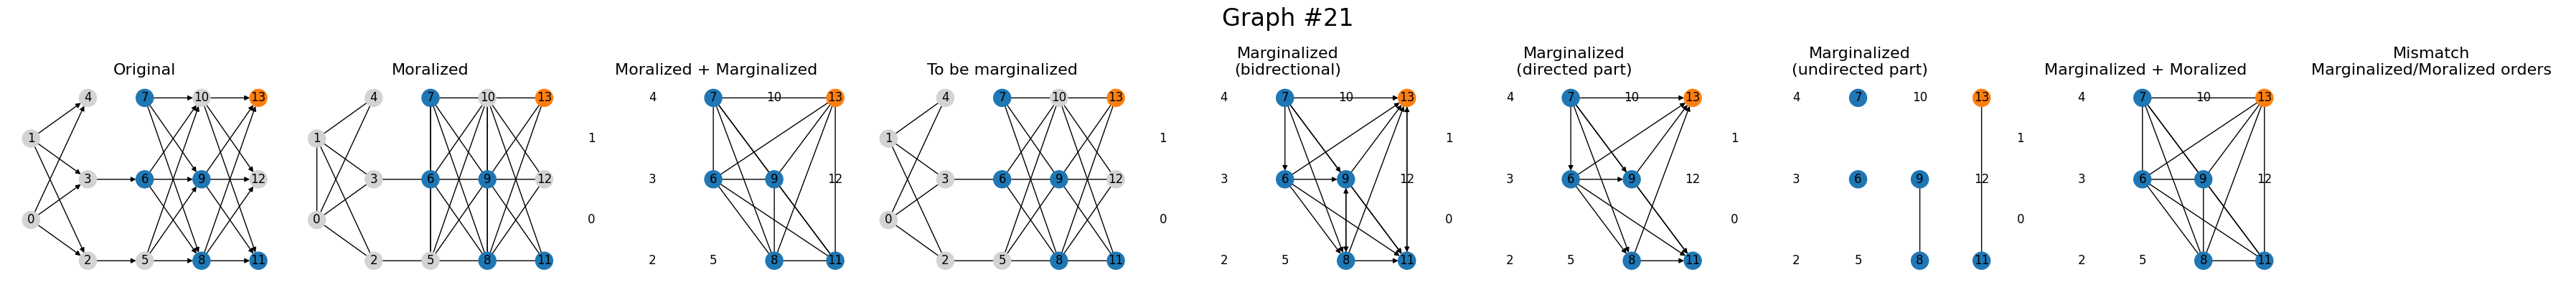

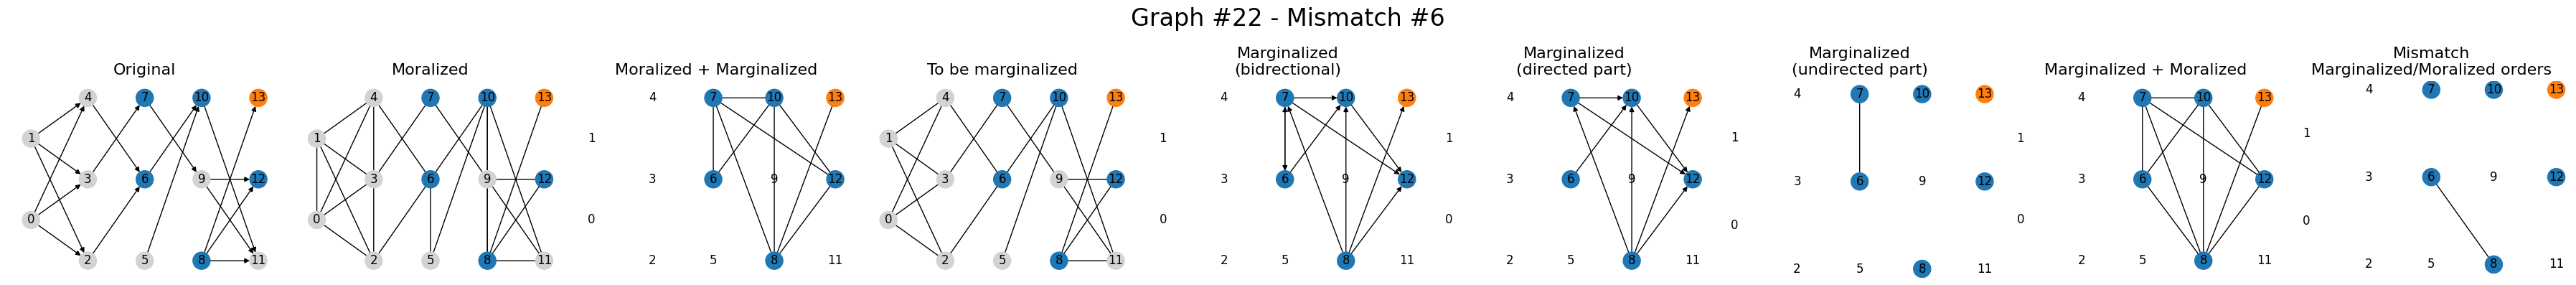

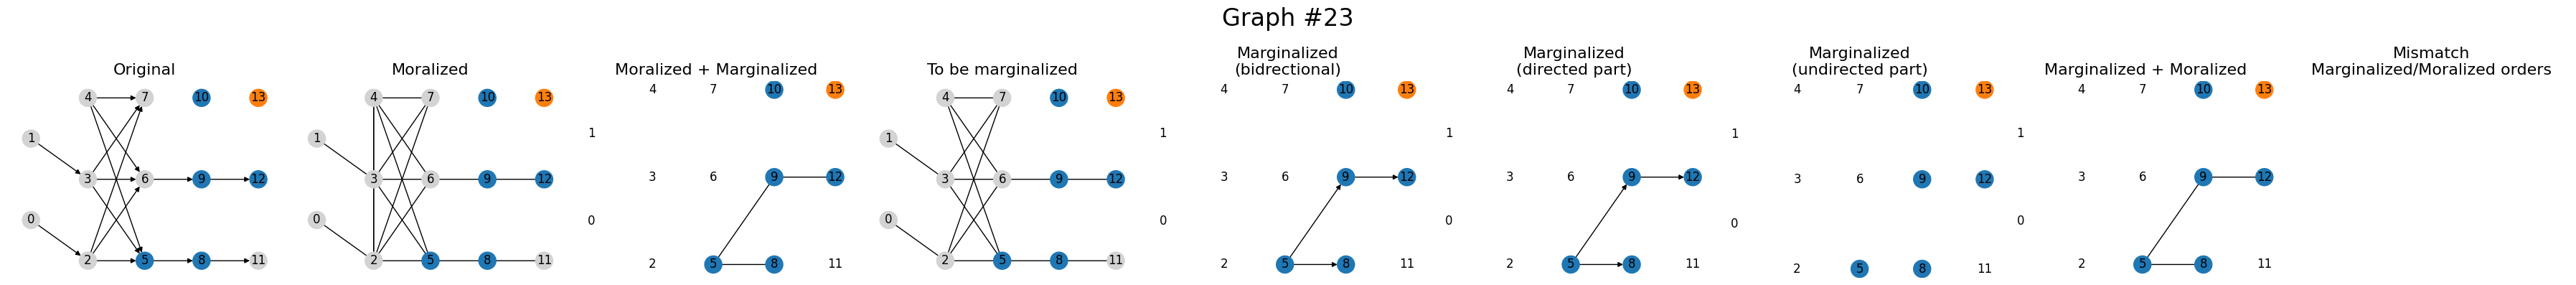

In [14]:
old_check(
    graphs, 
    # graphs_marg,
    # draw_scms_when = 'when_mismatch',
    poses = ['layer'],
)

In [15]:
# pos = nx.circular_layout(graph_moral_marg)
# nx.draw(graph_moral_marg, pos = pos,arrows = True, with_labels=True)
# plt.show()

# pos = nx.circular_layout(graph_marg_moral)
# nx.draw(graph_marg_moral, pos = pos,arrows = True, with_labels=True)
# plt.show()

# generations = get_generations(graph_org)
# generations
# graph_marg.remove_nodes_from(graph_marg.graph['nodes_exclude'])
# nx.adjacency_matrix(graph_marg).todense()
# graph_marg_moral.remove_nodes_from(graph_marg_moral.graph['nodes_exclude'])
# nx.adjacency_matrix(graph_marg_moral).todense()
# nx.adjacency_matrix(graph_marg).todense()
# imshow(nx.adjacency_matrix(graph_marg).todense())
# draw_scms(graph_marg, arrows=True)
# nx.moral_graph(graph_org).edges